<a href="https://colab.research.google.com/github/vipghn4/int3405-ml/blob/master/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [0]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=b2f84ffe0f20f71f195ea490cf4a6383122b52ad55fdb54c27e982259939c7c5
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import os

os.makedirs("data")

# Main code

## Import

In [0]:
import time

import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn import linear_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get data

In [0]:
def get_close_stock_price(codes, start_date='1900-01-01', end_date='2020-05-11'):
    data = { code : yf.download(code, start_date, end_date) for code in codes }
    data = { key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items() }
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])
df.to_csv('data/close_price_big_5.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
df = pd.read_csv('data/close_price_big_5.csv', 
                 index_col=['Date'], 
                 infer_datetime_format=True, 
                 parse_dates=['Date'])
df.head()

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2012-05-18,75.768570,300.500488,29.270000,213.850006,38.230000
2012-05-21,80.182854,307.362366,29.750000,218.110001,34.029999
2012-05-22,79.567146,300.700714,29.760000,215.330002,31.000000
2012-05-23,81.508568,305.035034,29.110001,217.279999,32.000000
2012-05-24,80.760002,302.132141,29.070000,215.240005,33.029999


## Visualize

In [0]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

False

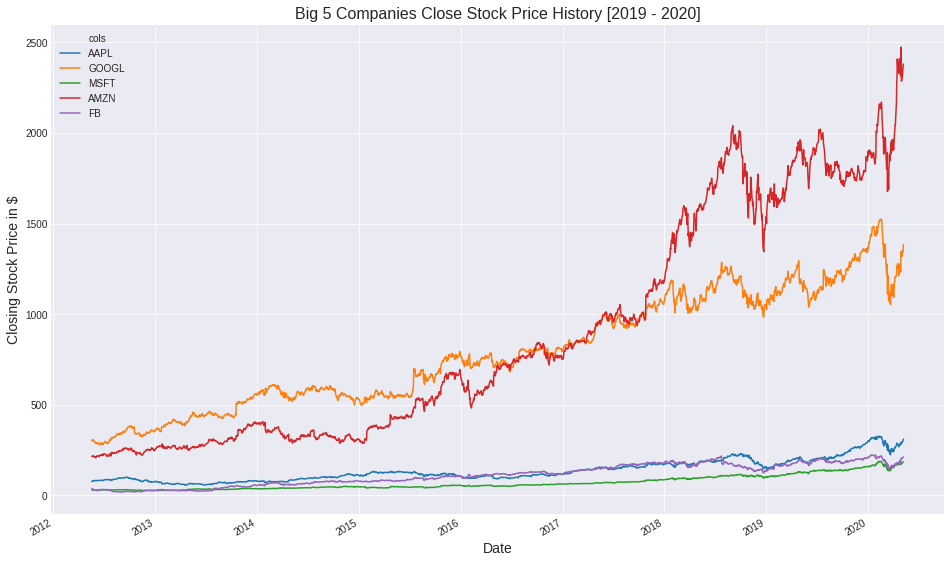

In [0]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Big 5 Companies Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

# Exercises

(2). Investigate if stock price of Big 5 companies are related to each other ( “FAAMG”—Facebook, Amazon, Apple, Microsoft, and Google )

(3). Determine the features that could predict future stock price ( stock price from Yahoo Finance could be considered as raw features, create new features if needed )
* Only 5 companies
* Only linear regression
* Only CLOSE price

**Answer (for exercise 2 and 3)**

We can sort the pairwise Pearson correlation as following
* $0.97$, i.e. GOOGL and FB
* $0.96$, i.e. GOOGL and AMZN
* $0.96$, i.e. MSFT and AMZN
* $0.96$, i.e. AAPL and MSFT
* $0.94$, i.e. GOOGL and MSFT
* $0.92$, i.e. AAPL and AMZN
* $0.92$, i.e. AAPL and GOOGL

One general comment is that the stocks of the big 5 tech companies are strongly correlated, with the least correlated pair is (AAPL, FB) with correlation score $0.87$. This is shown in the pairwise Pearson correlation plot. We can also see that FB is the one which have least correlation score with other companies, and GOOGL is the one which have most correlation score with others. The details about the correlation between stocks of big 5 compairs can be found in the pairwise scatter plots. 

For better correlation exploration, which may be useful for feature selection. We also, for each pair of companies (A, B), we use the price of A at every single day as features to predict the stock price of B on the same day. For better exploration, we exploited six different regressors. We then evaluate each regressor with R2 score. We then find that the R2 scores are all bad, i.e. no case can achieve $0.95$ R2 score. This is different when we have these six regressors trained on all features, i.e. stock prices of 5 companies in 5 previous days. Experiments show that predicting the stock price of a company using its previous prices works best for all of the big 5 companies. Thus, we do not use data from a company to predict stock price of another one.

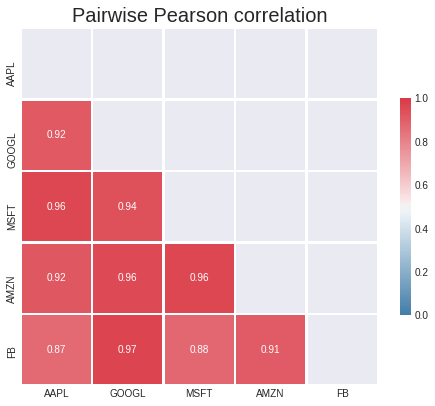

In [0]:
# Pairwise Pearson correlation plot
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 8))

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(
    df.corr(),
    mask=mask,
    cmap=cmap,
    annot=True,
    vmax=1,
    vmin=0,
    center=0.5,
    square=True,
    linewidths=1.5,
    cbar_kws={"shrink": .5})
plt.title("Pairwise Pearson correlation", fontsize=20)
plt.show()

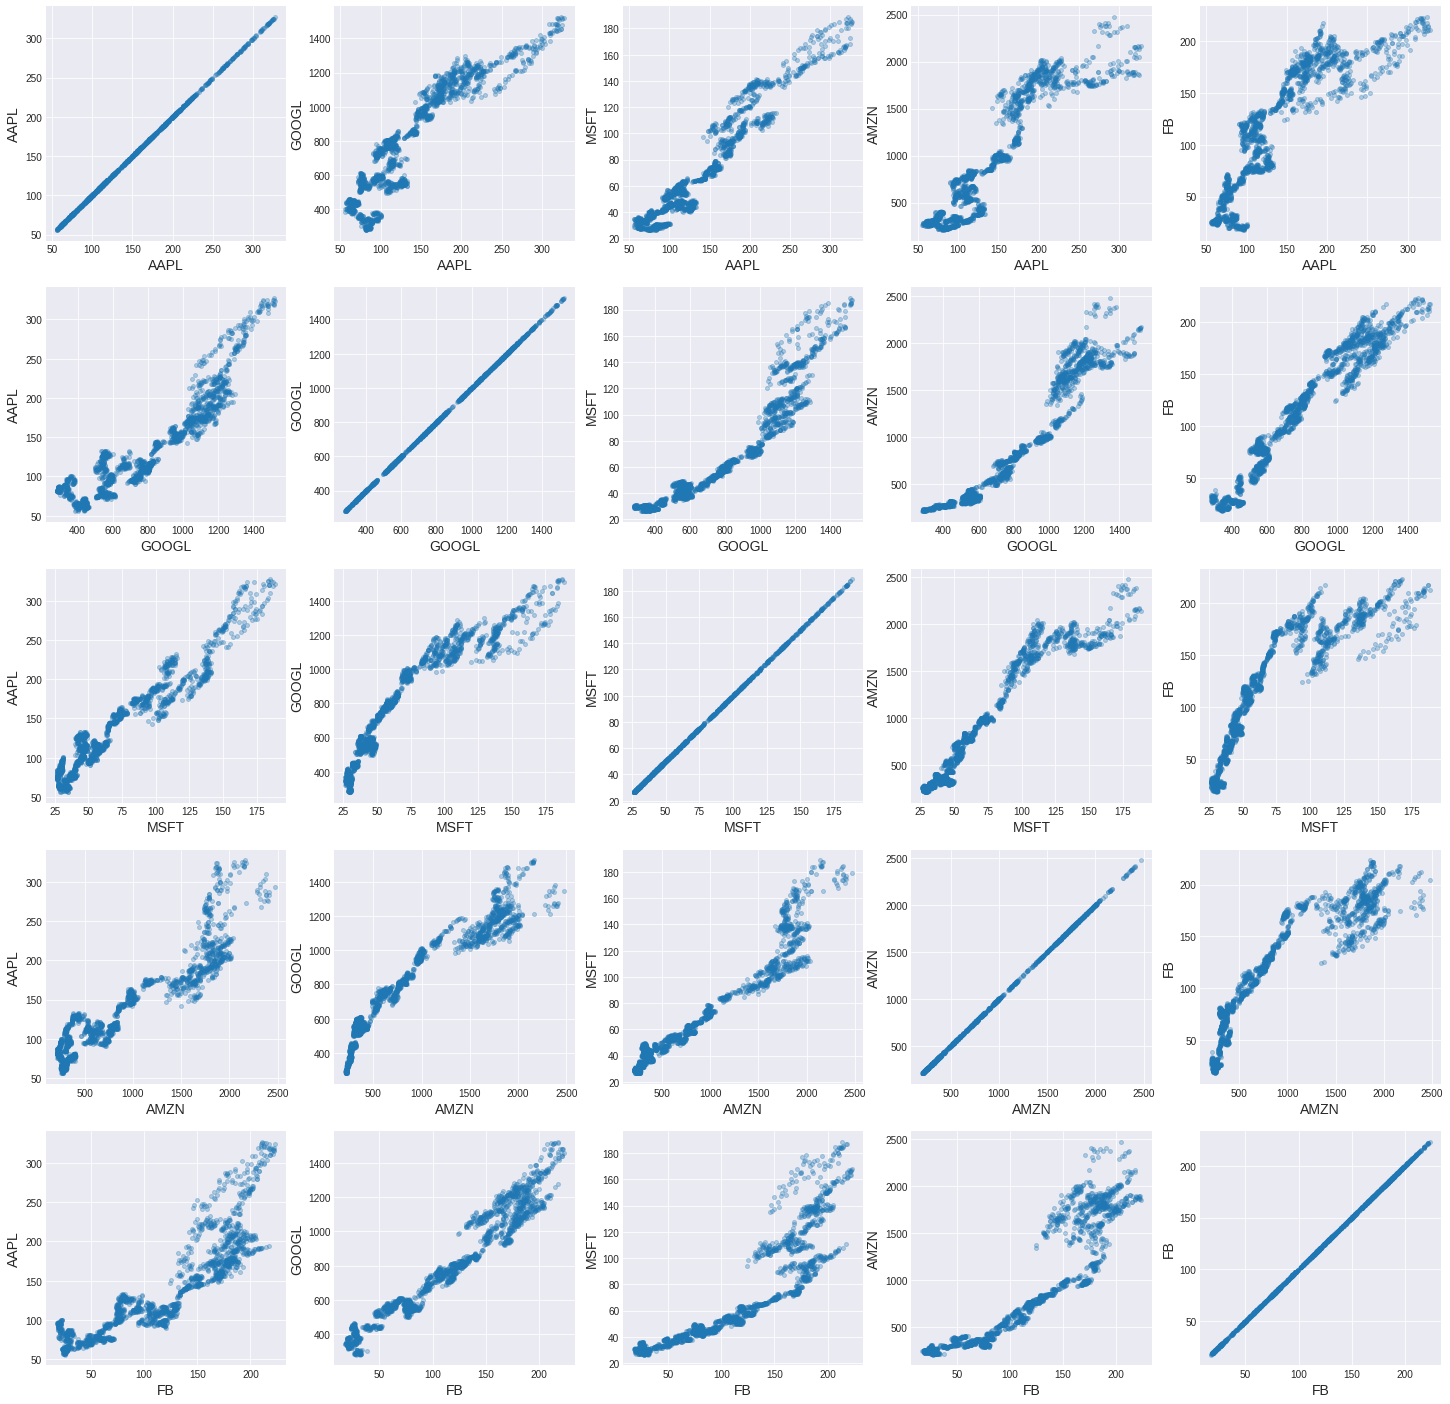

In [0]:
# Pairwise scatter plot
fig, ax = plt.subplots(5, 5, figsize=(25, 25))

for a, colA in enumerate(df):
    for b, colB in enumerate(df):
        ax[a, b].plot(df[colA], df[colB], "o", alpha=0.3)
        ax[a, b].set_xlabel(colA, fontsize=14)
        ax[a, b].set_ylabel(colB, fontsize=14)
plt.show()

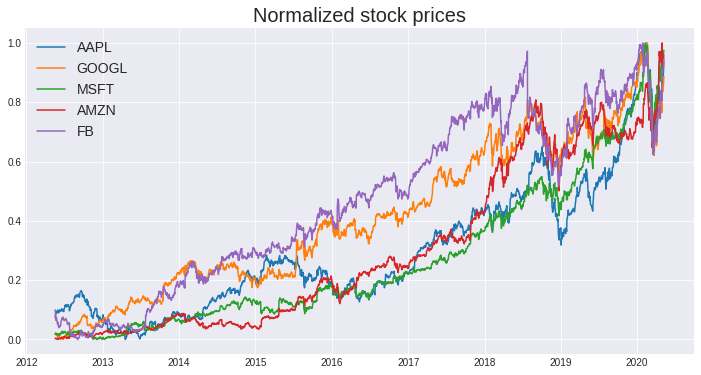

In [0]:
# Normalized stock price
plt.figure(figsize=(12, 6))
for col in df:
    normalized_col = (df[col] - df[col].min())/(df[col].max() - df[col].min())
    plt.plot(normalized_col, "-", label=col)
plt.title("Normalized stock prices", fontsize=20)
plt.legend(fontsize=14)
plt.show()

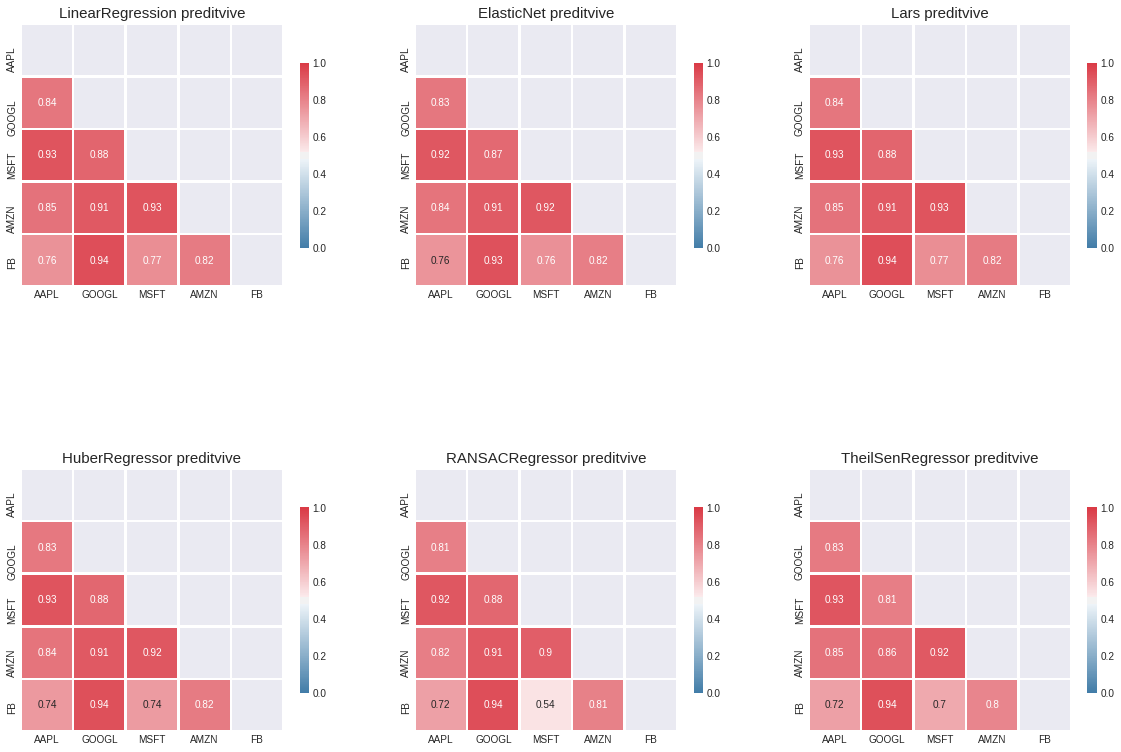

In [0]:
# Predictive
predictive = {
    "LinearRegression": pd.DataFrame(np.zeros((df.shape[1], df.shape[1]))),
    "ElasticNet": pd.DataFrame(np.zeros((df.shape[1], df.shape[1]))),
    "Lars": pd.DataFrame(np.zeros((df.shape[1], df.shape[1]))),
    "HuberRegressor": pd.DataFrame(np.zeros((df.shape[1], df.shape[1]))),
    "RANSACRegressor": pd.DataFrame(np.zeros((df.shape[1], df.shape[1]))),
    "TheilSenRegressor": pd.DataFrame(np.zeros((df.shape[1], df.shape[1]))),
}
for model in predictive:
    predictive[model].columns = df.columns
    predictive[model].index = df.columns

for A, colA in enumerate(df):
    for B, colB in enumerate(df):
        X, y = df[colA].values.reshape((-1, 1)), df[colB].values
        
        model = linear_model.LinearRegression(normalize=True)
        model.fit(X, y)
        score = model.score(X, y)
        predictive["LinearRegression"].at[colA, colB] = score

        model = linear_model.ElasticNet(normalize=True, alpha=1e-4)
        model.fit(X, y)
        score = model.score(X, y)
        predictive["ElasticNet"].at[colA, colB] = score

        model = linear_model.Lars(normalize=True)
        model.fit(X, y)
        score = model.score(X, y)
        predictive["Lars"].at[colA, colB] = score

        model = linear_model.HuberRegressor()
        model.fit(X, y)
        score = model.score(X, y)
        predictive["HuberRegressor"].at[colA, colB] = score

        model = linear_model.RANSACRegressor()
        model.fit(X, y)
        score = model.score(X, y)
        predictive["RANSACRegressor"].at[colA, colB] = score

        model = linear_model.TheilSenRegressor()
        model.fit(X, y)
        score = model.score(X, y)
        predictive["TheilSenRegressor"].at[colA, colB] = score

n_cols, n_rows = 2, 3
fig, ax = plt.subplots(n_cols, n_rows, figsize=(20, 15))
for model_idx, model in enumerate(predictive):
    mask = np.zeros_like(predictive[model], dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(
        predictive[model],
        mask=mask,
        cmap=cmap,
        annot=True,
        vmax=1,
        vmin=0,
        center=0.5,
        square=True,
        linewidths=1.5,
        cbar_kws={"shrink": .5},
        ax=ax[model_idx//n_rows, model_idx%n_rows])
    ax[model_idx//n_rows, model_idx%n_rows].set_title(f"{model} preditvive", fontsize=15)
plt.show()

In [0]:
feat_df = df.copy()

def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        X.append( feat_df.iloc[row_idx-history:row_idx,:].values.reshape(-1) )
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates

X,y,dates = create_Xy(df, history=5)
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = int(len(y) * 2 // 10)
(X_train, y_train, dates_train, X_test, y_test, dates_test) = (X[:n_train], 
                                                               y[:n_train], 
                                                               dates[:n_train], 
                                                               X[n_train:], 
                                                               y[n_train:], 
                                                               dates[n_train:])

In [0]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 25), (400, 5), (1601, 25), (1601, 5))

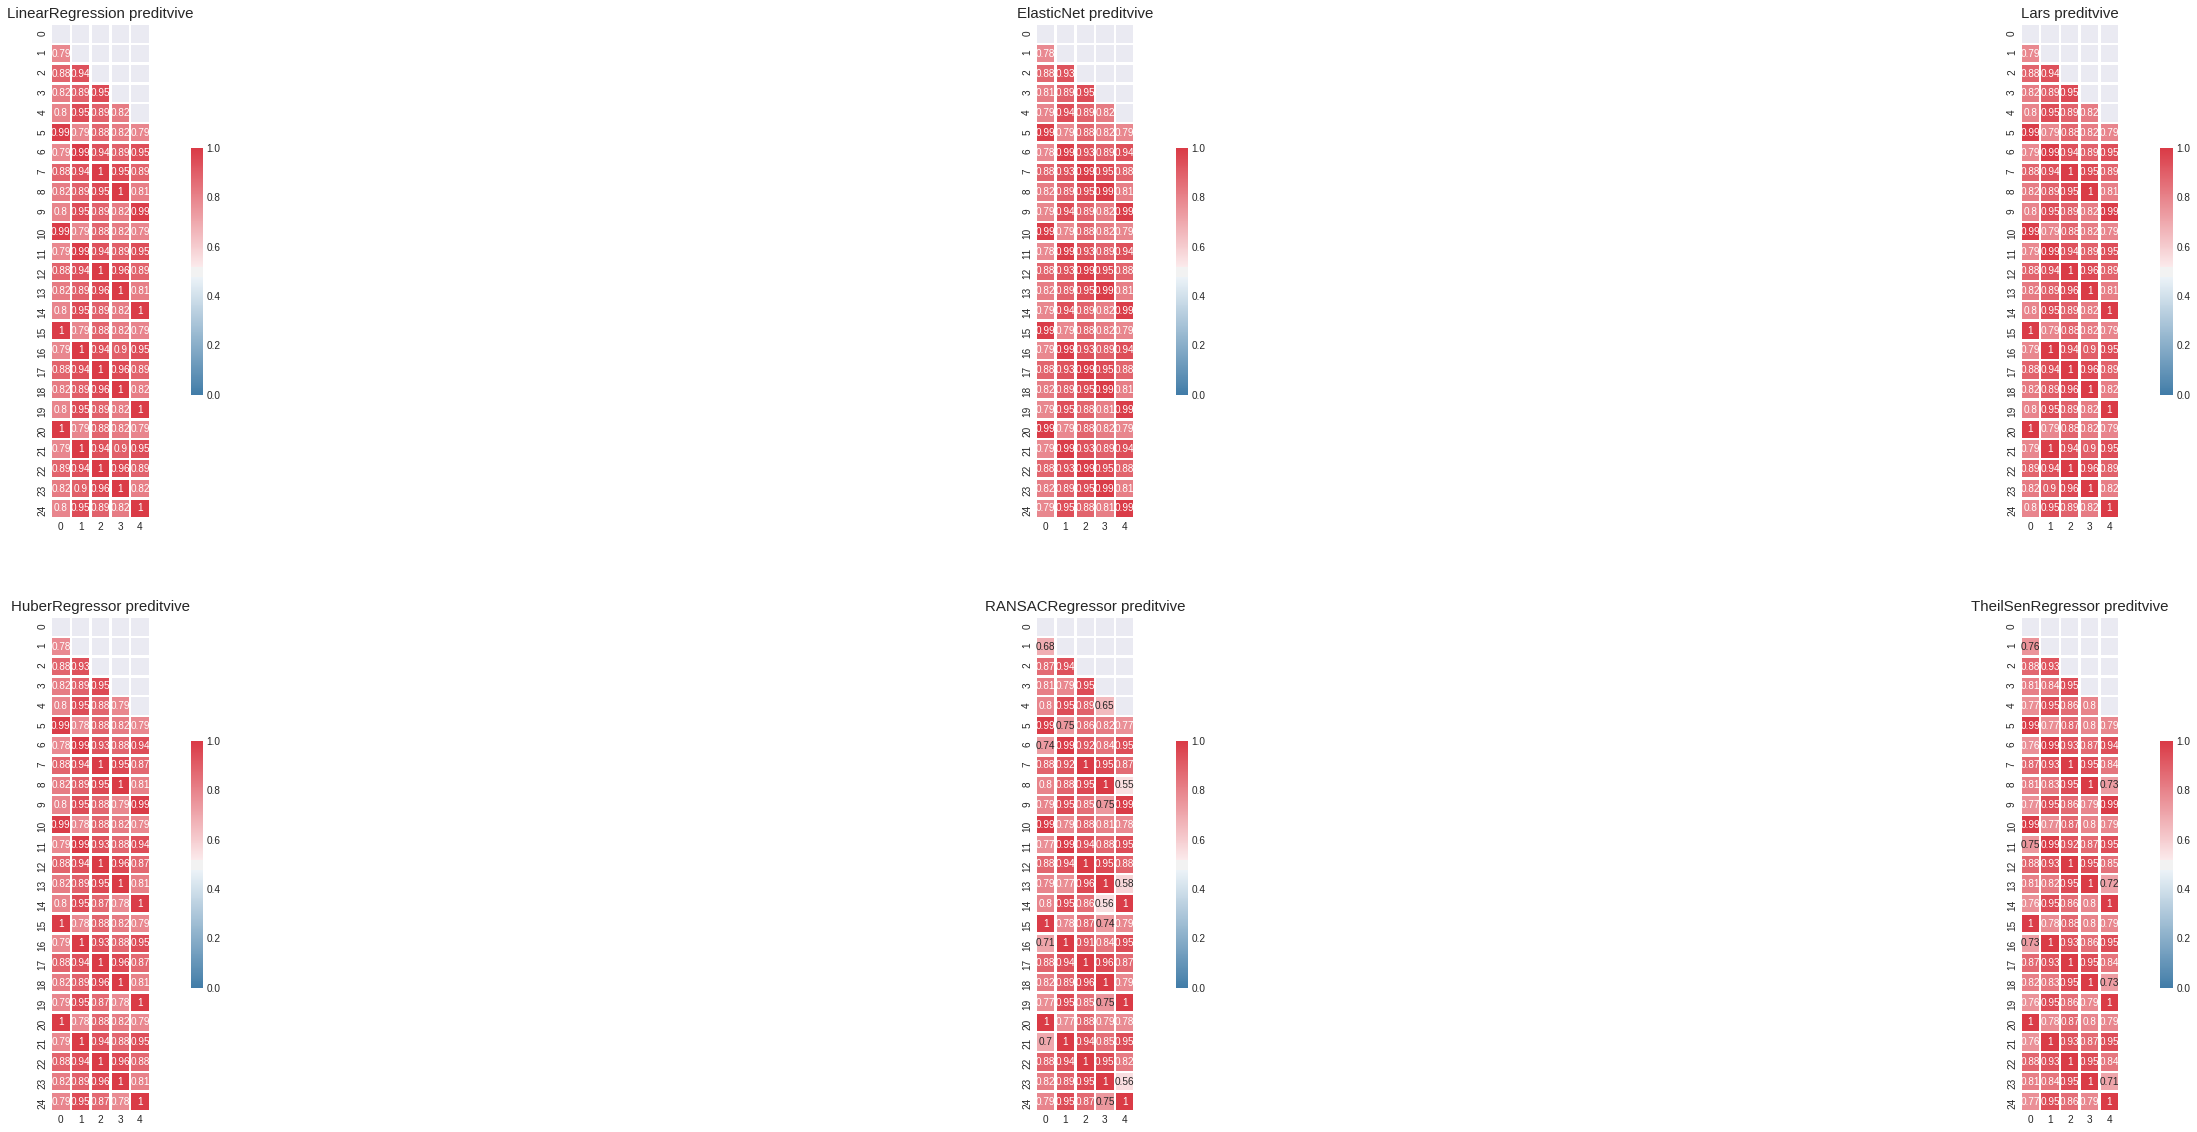

In [0]:
# Predictive
predictive = {
    "LinearRegression": pd.DataFrame(np.zeros((X_train.shape[1], y_train.shape[1]))),
    "ElasticNet": pd.DataFrame(np.zeros((X_train.shape[1], y_train.shape[1]))),
    "Lars": pd.DataFrame(np.zeros((X_train.shape[1], y_train.shape[1]))),
    "HuberRegressor": pd.DataFrame(np.zeros((X_train.shape[1], y_train.shape[1]))),
    "RANSACRegressor": pd.DataFrame(np.zeros((X_train.shape[1], y_train.shape[1]))),
    "TheilSenRegressor": pd.DataFrame(np.zeros((X_train.shape[1], y_train.shape[1]))),
}

for A in range(X_train.shape[1]):
    for B in range(y_train.shape[1]):
        X, y = X_train[:, A].reshape((-1, 1)), y_train[:, B]
        
        model = linear_model.LinearRegression(normalize=True)
        model.fit(X, y)
        score = model.score(X, y)
        predictive["LinearRegression"].at[A, B] = score

        model = linear_model.ElasticNet(normalize=True, alpha=1e-4)
        model.fit(X, y)
        score = model.score(X, y)
        predictive["ElasticNet"].at[A, B] = score

        model = linear_model.Lars(normalize=True)
        model.fit(X, y)
        score = model.score(X, y)
        predictive["Lars"].at[A, B] = score

        model = linear_model.HuberRegressor()
        model.fit(X, y)
        score = model.score(X, y)
        predictive["HuberRegressor"].at[A, B] = score

        model = linear_model.RANSACRegressor()
        model.fit(X, y)
        score = model.score(X, y)
        predictive["RANSACRegressor"].at[A, B] = score

        model = linear_model.TheilSenRegressor()
        model.fit(X, y)
        score = model.score(X, y)
        predictive["TheilSenRegressor"].at[A, B] = score

# Visualize
n_cols, n_rows = 2, 3
fig, ax = plt.subplots(n_cols, n_rows, figsize=(50, 20))
for model_idx, model in enumerate(predictive):
    mask = np.zeros_like(predictive[model], dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(
        predictive[model],
        mask=mask,
        cmap=cmap,
        annot=True,
        vmax=1,
        vmin=0,
        center=0.5,
        square=True,
        linewidths=1.5,
        cbar_kws={"shrink": .5},
        ax=ax[model_idx//n_rows, model_idx%n_rows])
    ax[model_idx//n_rows, model_idx%n_rows].set_title(f"{model} preditvive", fontsize=15)
plt.show()

(4). Build a linear regression model to predict future stock price

(5). Evaluate your model performance

**Code (for exercise 4 and 5)**

Loss of LinearRegression: [11.778509365669242, 255.17769274009734, 3.6306231082748086, 572.8419005875877, 8.34063795410652] - Mean loss: 170.35387275114712
Loss of Lars: [11.778509365669414, 255.1776927400995, 3.6306231082747495, 572.8419005875854, 8.340637954106771] - Mean loss: 170.35387275114718
Loss of HuberRegressor: [11.251322544457043, 258.3936224363712, 3.3294512058799137, 560.7927083831148, 8.47591540299293] - Mean loss: 168.44860399456317
Loss of RANSACRegressor: [11.810930309840499, 257.6736925739011, 3.418601837191434, 560.1342541055698, 13.590544948330935] - Mean loss: 169.32560475496675
Loss of TheilSenRegressor: [11.08282285836605, 264.89605026072763, 3.5447454025629845, 563.1439805349675, 8.297088987444132] - Mean loss: 170.19293760881365
Loss of Ensemble: [11.47809913865162, 256.9549063572801, 3.4870747063864913, 563.9605348941136, 8.684934360503595] - Mean loss: 168.91310989138705


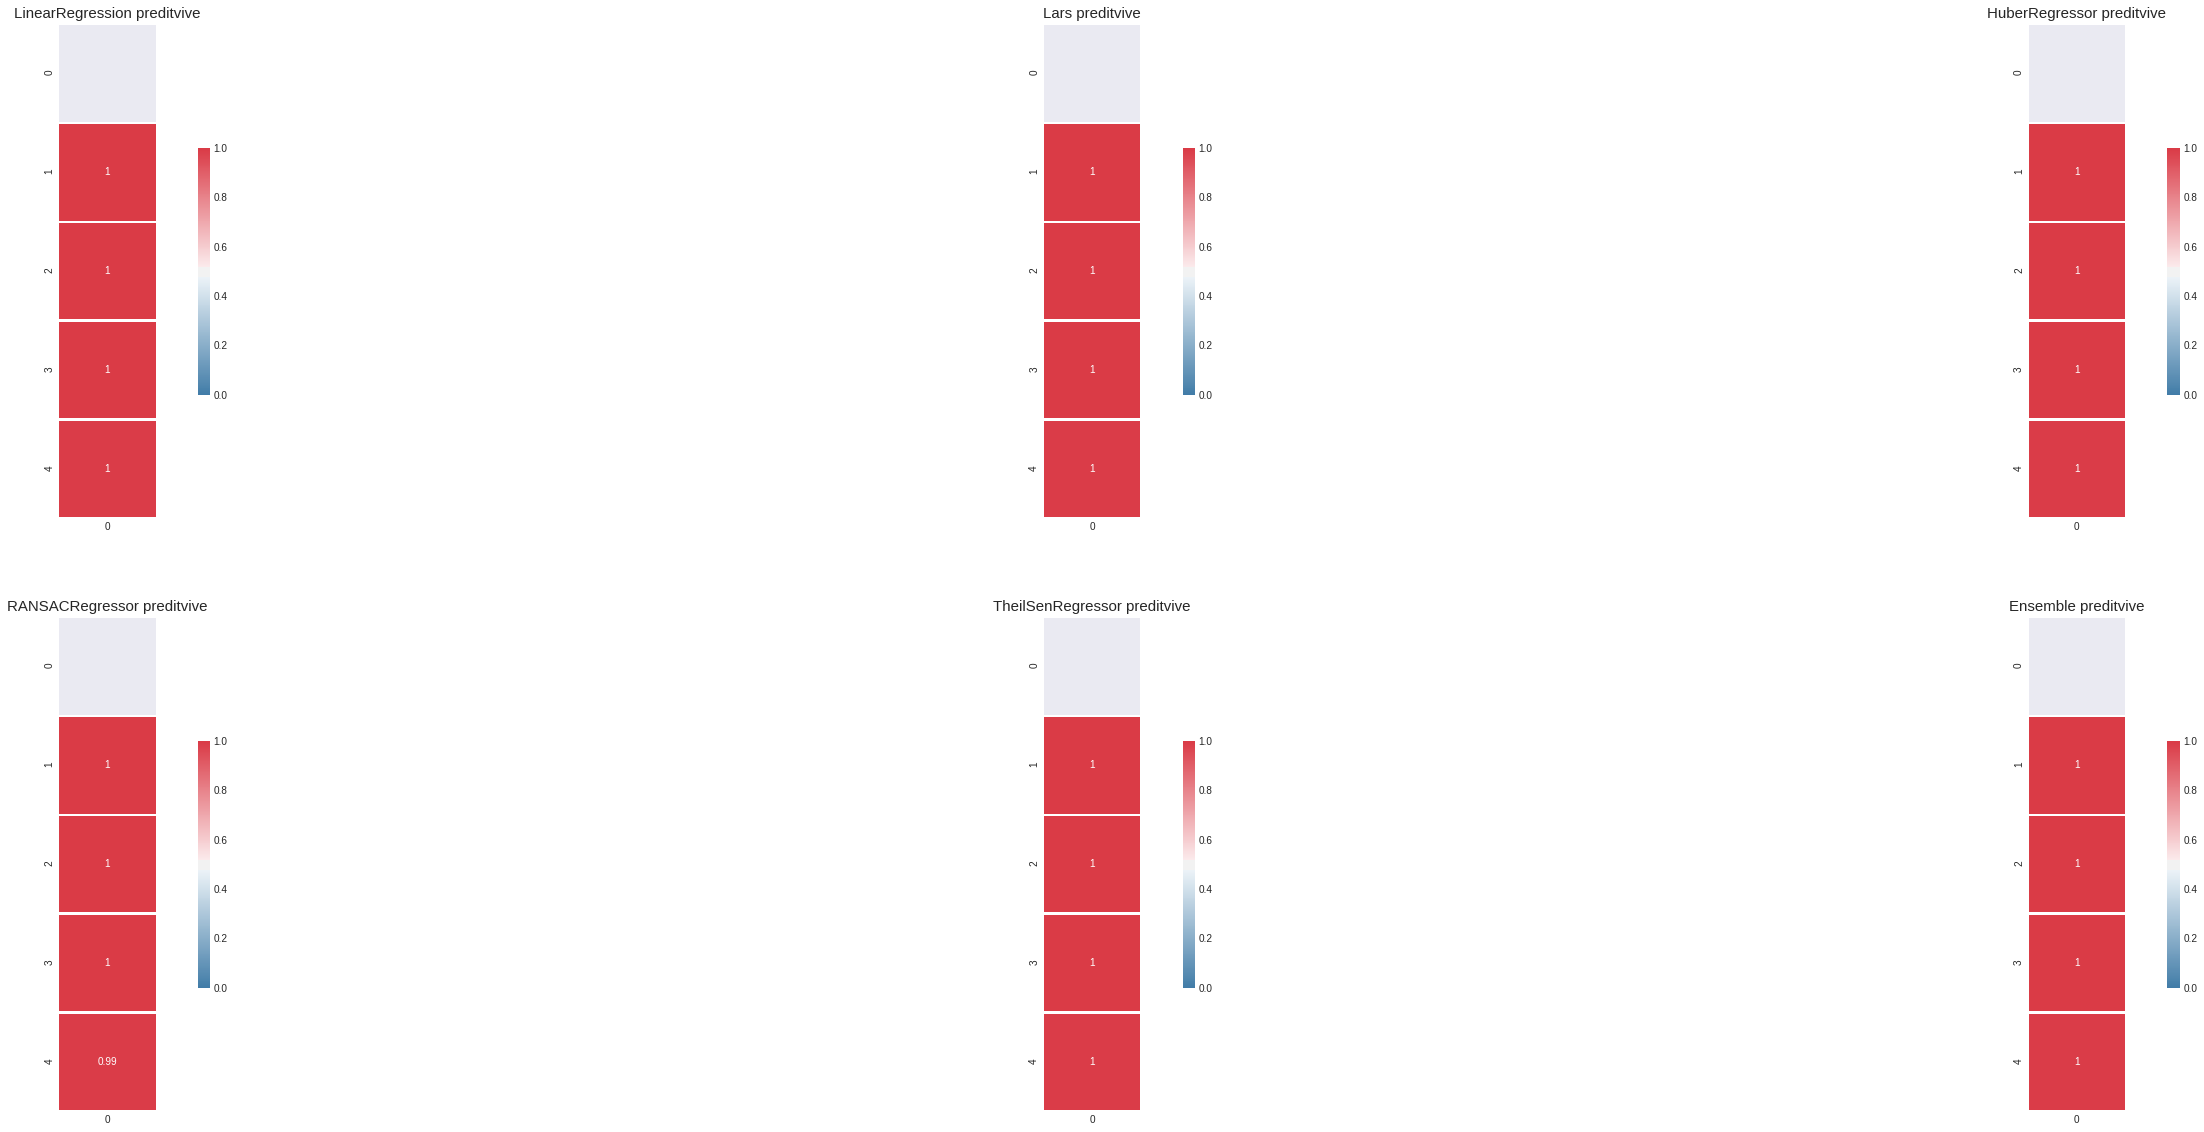

In [0]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictive
predictive = {
    "LinearRegression": pd.DataFrame(np.zeros((y_train.shape[1], ))),
    "Lars": pd.DataFrame(np.zeros((y_train.shape[1], ))),
    "HuberRegressor": pd.DataFrame(np.zeros((y_train.shape[1], ))),
    "RANSACRegressor": pd.DataFrame(np.zeros((y_train.shape[1], ))),
    "TheilSenRegressor": pd.DataFrame(np.zeros((y_train.shape[1], ))),
    "Ensemble": pd.DataFrame(np.zeros((y_train.shape[1], ))),
}

loss = {
    "LinearRegression": [],
    "Lars": [],
    "HuberRegressor": [],
    "RANSACRegressor": [],
    "TheilSenRegressor": [],
    "Ensemble": []
}

for B in range(y_train.shape[1]):
    models = {
        "LinearRegression": linear_model.LinearRegression(normalize=True),
        "Lars": linear_model.Lars(normalize=True),
        "HuberRegressor": linear_model.HuberRegressor(),
        "RANSACRegressor": linear_model.RANSACRegressor(),
        "TheilSenRegressor": linear_model.TheilSenRegressor(),
    }

    chosen_feats = np.arange(0, 25)[5+B::5]
    X, y = X_train[:, chosen_feats].reshape((-1, len(chosen_feats))), y_train[:, B]
    Xt, yt = X_test[:, chosen_feats].reshape((-1, len(chosen_feats))), y_test[:, B]

    for model in models:
        models[model].fit(X, y)
        y_pred = models[model].predict(Xt)
        mse = mean_squared_error(y_pred, yt)
        loss[model].append(mse)
        score = models[model].score(Xt, yt)
        predictive[model].at[B] = score
    
    # Ensemble
    y_pred = np.array([models[model].predict(Xt) for model in models])
    y_pred = np.mean(y_pred, axis=0)
    mse = mean_squared_error(y_pred, yt)
    loss["Ensemble"].append(mse)
    score = r2_score(yt, y_pred)
    predictive["Ensemble"].at[B] = score


# Visualize
for model in loss:
    print(f"Loss of {model}: {loss[model]} - Mean loss: {np.mean(loss[model])}")

n_cols, n_rows = 2, 3
fig, ax = plt.subplots(n_cols, n_rows, figsize=(50, 20))
for model_idx, model in enumerate(predictive):
    mask = np.zeros_like(predictive[model], dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(
        predictive[model],
        mask=mask,
        cmap=cmap,
        annot=True,
        vmax=1,
        vmin=0,
        center=0.5,
        square=True,
        linewidths=1.5,
        cbar_kws={"shrink": .5},
        ax=ax[model_idx//n_rows, model_idx%n_rows])
    ax[model_idx//n_rows, model_idx%n_rows].set_title(f"{model} preditvive", fontsize=15)
plt.show()